In [ ]:
import pandas as pd

# FILE PATHS
master_path = "/content/drive/MyDrive/Data_Science_Projects/Customer_Complaint_Trend_Forecasting/data/BI_MASTER_DATA_CLEAN.csv"
stable_path = "/content/drive/MyDrive/Data_Science_Projects/Customer_Complaint_Trend_Forecasting/data/stable_pairs.csv"

# OUTPUT FILE
out_path = "/content/drive/MyDrive/Data_Science_Projects/Customer_Complaint_Trend_Forecasting/data/timeline_cleaned_final.csv"

# LOAD FILES
master = pd.read_csv(master_path)
stable = pd.read_csv(stable_path)

# --- CLEAN STABLE PAIRS ---
# Ensure names match master file
stable.columns = ["Product", "State"]

# --- FILTER MASTER TO ONLY STABLE PAIRS ---
df = master.merge(stable, on=["Product", "State"], how="inner")

# --- FIX DUPLICATES (if any) ---
df = df.drop_duplicates(subset=["Product", "State", "ds"])

# --- SORT PROPERLY FOR VISUALIZATION ---
df = df.sort_values(["Product", "State", "ds"])

# --- FINAL CHECKS ---
df = df.reset_index(drop=True)

# SAVE
df.to_csv(out_path, index=False)

print("✔ FINAL DATASET READY!")
print("Saved at:", out_path)
print("Final shape:", df.shape)
print(df.head())

✔ FINAL DATASET READY!
Saved at: /content/drive/MyDrive/Data_Science_Projects/Customer_Complaint_Trend_Forecasting/data/timeline_cleaned_final.csv
Final shape: (5808, 12)
           ds                      Product State  actual_count  topic  \
0  2020-11-01  CHECKING OR SAVINGS ACCOUNT    DC           4.0    1.0   
1  2020-12-01  CHECKING OR SAVINGS ACCOUNT    DC           2.0    1.0   
2  2021-01-01  CHECKING OR SAVINGS ACCOUNT    DC           1.0    1.0   
3  2021-02-01  CHECKING OR SAVINGS ACCOUNT    DC           2.0    1.0   
4  2021-03-01  CHECKING OR SAVINGS ACCOUNT    DC           3.0    1.0   

   topic_count              topic_keywords  \
0        844.0  bank, was, card, they, the   
1        844.0  bank, was, card, they, the   
2        844.0  bank, was, card, they, the   
3        844.0  bank, was, card, they, the   
4        844.0  bank, was, card, they, the   

                        topic_interpretation  year  month_num  forecast_count  \
0  Card-related dispute or trans

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Data_Science_Projects/Customer_Complaint_Trend_Forecasting/data/timeline_cleaned_final.csv")

# Count forecast rows per Product-State
fc_check = (
    df[df['forecast_count'].notna()]
      .groupby(['Product','State'])
      .size()
)

print("Forecast rows per pair:")
print(fc_check.head(), "\n")

print("Pairs missing forecast rows:")
print(fc_check[fc_check == 0])

Forecast rows per pair:
Product                      State
CHECKING OR SAVINGS ACCOUNT  DC       12
                             DE       12
                             GA       12
                             KS       12
                             MI       12
dtype: int64 

Pairs missing forecast rows:
Series([], dtype: int64)


In [ ]:
import pandas as pd

# Load master file
file_path = "/content/drive/MyDrive/Data_Science_Projects/Customer_Complaint_Trend_Forecasting/data/BI_MASTER_DATA_CLEAN.csv"
df = pd.read_csv(file_path)

# Ensure ds is datetime
df['ds'] = pd.to_datetime(df['ds'])

# --- STEP 1: For each Product-State-Month, pick the row with highest topic_count ---
df['topic_count'] = df['topic_count'].fillna(0)

df_unique = df.sort_values(['Product', 'State', 'ds', 'topic_count'], ascending=[True, True, True, False])\
              .drop_duplicates(subset=['Product','State','ds'], keep='first')

# --- STEP 2: Make sure actual_count & forecast_count are numeric ---
df_unique['actual_count'] = pd.to_numeric(df_unique['actual_count'], errors='coerce')
df_unique['forecast_count'] = pd.to_numeric(df_unique['forecast_count'], errors='coerce')

# --- STEP 3: Keep only needed columns ---
final_cols = [
    'ds', 'Product', 'State',
    'actual_count', 'forecast_count',
    'topic', 'topic_count',
    'topic_keywords', 'topic_interpretation'
]

df_final = df_unique[final_cols].copy()

# --- STEP 4: Sort properly ---
df_final = df_final.sort_values(['Product','State','ds'])

# --- STEP 5: Save cleaned file ---
out_path = "/content/drive/MyDrive/Data_Science_Projects/Customer_Complaint_Trend_Forecasting/data/timeline_clean_final.csv"
df_final.to_csv(out_path, index=False)

print("✔ FINAL CLEAN FILE SAVED!")
print("PATH:", out_path)
print("Shape:", df_final.shape)
print(df_final.head())

✔ FINAL CLEAN FILE SAVED!
PATH: /content/drive/MyDrive/Data_Science_Projects/Customer_Complaint_Trend_Forecasting/data/timeline_clean_final.csv
Shape: (22782, 9)
          ds                      Product State  actual_count  forecast_count  \
0 2021-02-01  CHECKING OR SAVINGS ACCOUNT    AK           1.0             NaN   
2 2021-07-01  CHECKING OR SAVINGS ACCOUNT    AK           2.0             NaN   
4 2022-06-01  CHECKING OR SAVINGS ACCOUNT    AK           1.0             NaN   
6 2022-10-01  CHECKING OR SAVINGS ACCOUNT    AK           1.0             NaN   
8 2022-11-01  CHECKING OR SAVINGS ACCOUNT    AK           1.0             NaN   

   topic  topic_count              topic_keywords  \
0    1.0        844.0  bank, was, card, they, the   
2    1.0        844.0  bank, was, card, they, the   
4    1.0        844.0  bank, was, card, they, the   
6    1.0        844.0  bank, was, card, they, the   
8    1.0        844.0  bank, was, card, they, the   

                        topic_in

In [ ]:
import pandas as pd

# Load master BI file
df = pd.read_csv("/content/drive/MyDrive/Data_Science_Projects/Customer_Complaint_Trend_Forecasting/data/BI_MASTER_DATA_CLEAN.csv")

# --- CLEAN DATES ---
df['ds'] = pd.to_datetime(df['ds'], errors='coerce')
df['ds'] = df['ds'].dt.to_period('M').dt.to_timestamp()  # normalize monthly

# Numeric conversions
df['actual_count'] = pd.to_numeric(df['actual_count'], errors='coerce')
df['forecast_count'] = pd.to_numeric(df['forecast_count'], errors='coerce')
df['topic_count'] = pd.to_numeric(df['topic_count'], errors='coerce').fillna(0)

# Grouping
grouped = []

for (prod, state, date), grp in df.groupby(['Product','State','ds']):

    actual = grp['actual_count'].sum(skipna=True)
    forecast = grp['forecast_count'].mean(skipna=True)

    best = grp.sort_values("topic_count", ascending=False).iloc[0]

    grouped.append({
        'ds': date,
        'Product': prod,
        'State': state,
        'actual_count': actual if actual != 0 else None,
        'forecast_count': forecast if pd.notna(forecast) else None,
        'topic': best['topic'],
        'topic_count': best['topic_count'],
        'topic_keywords': best['topic_keywords'],
        'topic_interpretation': best['topic_interpretation']
    })

final = pd.DataFrame(grouped)
final = final.sort_values(['Product','State','ds'])

out_path = "/content/drive/MyDrive/Data_Science_Projects/Customer_Complaint_Trend_Forecasting/data/timeline_clean_final.csv"
final.to_csv(out_path, index=False)

print("✔ SAVED:", out_path)
print("✔ New shape:", final.shape)
print(final.head())

✔ SAVED: /content/drive/MyDrive/Data_Science_Projects/Customer_Complaint_Trend_Forecasting/data/timeline_clean_final.csv
✔ New shape: (22782, 9)
          ds                      Product State  actual_count  forecast_count  \
0 2021-02-01  CHECKING OR SAVINGS ACCOUNT    AK           2.0             NaN   
1 2021-07-01  CHECKING OR SAVINGS ACCOUNT    AK           4.0             NaN   
2 2022-06-01  CHECKING OR SAVINGS ACCOUNT    AK           2.0             NaN   
3 2022-10-01  CHECKING OR SAVINGS ACCOUNT    AK           2.0             NaN   
4 2022-11-01  CHECKING OR SAVINGS ACCOUNT    AK           2.0             NaN   

   topic  topic_count              topic_keywords  \
0    1.0        844.0  bank, was, card, they, the   
1    1.0        844.0  bank, was, card, they, the   
2    1.0        844.0  bank, was, card, they, the   
3    1.0        844.0  bank, was, card, they, the   
4    1.0        844.0  bank, was, card, they, the   

                        topic_interpretation  
0 

In [ ]:
import pandas as pd

# Load your final cleaned dataset
path = "/content/drive/MyDrive/Data_Science_Projects/Customer_Complaint_Trend_Forecasting/data/timeline_cleaned_final.csv"
df = pd.read_csv(path, parse_dates=['ds'])

# ==============================
# FILE 1 — CLEAN TIME SERIES FILE
# ==============================

ts_cols = ['ds', 'Product', 'State', 'actual_count', 'forecast_count']

df_ts = df[ts_cols].copy()

# Ensure numeric
df_ts['actual_count'] = pd.to_numeric(df_ts['actual_count'], errors='coerce')
df_ts['forecast_count'] = pd.to_numeric(df_ts['forecast_count'], errors='coerce')

# Sort properly (super important for Tableau)
df_ts = df_ts.sort_values(['Product', 'State', 'ds']).reset_index(drop=True)

# Save
ts_path = "/content/drive/MyDrive/Data_Science_Projects/Customer_Complaint_Trend_Forecasting/data/timeline_for_linecharts.csv"
df_ts.to_csv(ts_path, index=False)

print("✔ TIMELINE FILE SAVED:", ts_path)
print("Shape:", df_ts.shape)
print(df_ts.head())


# ==============================
# FILE 2 — TOPIC INSIGHTS FILE
# ==============================

topic_cols = [
    'ds', 'Product', 'State',
    'topic', 'topic_count',
    'topic_keywords', 'topic_interpretation'
]

df_topic = df[topic_cols].copy()

# Replace forecast rows (which have NaN topic) with empty strings — SAFE for Tableau
df_topic['topic'] = df_topic['topic'].fillna("")
df_topic['topic_count'] = df_topic['topic_count'].fillna(0)
df_topic['topic_keywords'] = df_topic['topic_keywords'].fillna("")
df_topic['topic_interpretation'] = df_topic['topic_interpretation'].fillna("")

df_topic = df_topic.sort_values(['Product', 'State', 'ds']).reset_index(drop=True)

# Save
topic_path = "/content/drive/MyDrive/Data_Science_Projects/Customer_Complaint_Trend_Forecasting/data/topic_insights_clean.csv"
df_topic.to_csv(topic_path, index=False)

print("\n✔ TOPIC INSIGHTS FILE SAVED:", topic_path)
print("Shape:", df_topic.shape)
print(df_topic.head())

✔ TIMELINE FILE SAVED: /content/drive/MyDrive/Data_Science_Projects/Customer_Complaint_Trend_Forecasting/data/timeline_for_linecharts.csv
Shape: (5808, 5)
          ds                      Product State  actual_count  forecast_count
0 2020-11-01  CHECKING OR SAVINGS ACCOUNT    DC           4.0             NaN
1 2020-12-01  CHECKING OR SAVINGS ACCOUNT    DC           2.0             NaN
2 2021-01-01  CHECKING OR SAVINGS ACCOUNT    DC           1.0             NaN
3 2021-02-01  CHECKING OR SAVINGS ACCOUNT    DC           2.0             NaN
4 2021-03-01  CHECKING OR SAVINGS ACCOUNT    DC           3.0             NaN

✔ TOPIC INSIGHTS FILE SAVED: /content/drive/MyDrive/Data_Science_Projects/Customer_Complaint_Trend_Forecasting/data/topic_insights_clean.csv
Shape: (5808, 7)
          ds                      Product State topic  topic_count  \
0 2020-11-01  CHECKING OR SAVINGS ACCOUNT    DC   1.0        844.0   
1 2020-12-01  CHECKING OR SAVINGS ACCOUNT    DC   1.0        844.0   
2 2021-0

In [ ]:
import pandas as pd

# === INPUT FILES ===
main_path = "/content/drive/MyDrive/Data_Science_Projects/Customer_Complaint_Trend_Forecasting/data/timeline_cleaned_final.csv"
stable_path = "/content/drive/MyDrive/Data_Science_Projects/Customer_Complaint_Trend_Forecasting/data/stable_pairs.csv"

# === LOAD DATA ===
df = pd.read_csv(main_path)
stable = pd.read_csv(stable_path)

# Normalize stable pairs column names if needed
stable.columns = ["Product", "State"]

# === 1. KEEP ONLY STABLE PAIRS ===
df = df.merge(stable, on=["Product", "State"], how="inner")

# === 2. REMOVE ROOT-CAUSE DUPLICATE INFLATION ===
# If same Product/State/date has multiple topic rows → keep the one with max topic_count
df = df.sort_values(["Product","State","ds","topic_count"], ascending=[True,True,True,False])
df = df.drop_duplicates(subset=["Product","State","ds"], keep="first")

# === 3. FIX DATA TYPES ===
df["ds"] = pd.to_datetime(df["ds"], errors="coerce")
df["actual_count"] = pd.to_numeric(df["actual_count"], errors="coerce")
df["forecast_count"] = pd.to_numeric(df["forecast_count"], errors="coerce")

# === 4. ENSURE ONE ROW PER MONTH (for actual or forecast) ===
# If both exist → actual is kept separately, but forecast stays null (correct)
# No need to fill zeros or expand dates.

# === 5. SORT CLEANLY ===
df = df.sort_values(["Product","State","ds"]).reset_index(drop=True)

# === 6. SAVE CLEAN FILE ===
out = "/content/drive/MyDrive/Data_Science_Projects/Customer_Complaint_Trend_Forecasting/data/all_set_for_visuals.csv"
df.to_csv(out, index=False)

print("✔ FINAL VISUALIZATION FILE SAVED!")
print("PATH:", out)
print("ROWS:", df.shape)
print("COLUMNS:", df.columns.tolist())

✔ FINAL VISUALIZATION FILE SAVED!
PATH: /content/drive/MyDrive/Data_Science_Projects/Customer_Complaint_Trend_Forecasting/data/all_set_for_visuals.csv
ROWS: (5808, 12)
COLUMNS: ['ds', 'Product', 'State', 'actual_count', 'topic', 'topic_count', 'topic_keywords', 'topic_interpretation', 'year', 'month_num', 'forecast_count', 'model']


In [1]:
import pandas as pd

file = "/content/drive/MyDrive/Data_Science_Projects/Customer_Complaint_Trend_Forecasting/data/all_set_for_visuals.csv"

df = pd.read_csv(file, parse_dates=["ds"])

print(df.head())
print(df.shape)
print(df.dtypes)
print(df.isna().sum())

          ds                      Product State  actual_count  topic  \
0 2020-11-01  CHECKING OR SAVINGS ACCOUNT    DC           4.0    1.0   
1 2020-12-01  CHECKING OR SAVINGS ACCOUNT    DC           2.0    1.0   
2 2021-01-01  CHECKING OR SAVINGS ACCOUNT    DC           1.0    1.0   
3 2021-02-01  CHECKING OR SAVINGS ACCOUNT    DC           2.0    1.0   
4 2021-03-01  CHECKING OR SAVINGS ACCOUNT    DC           3.0    1.0   

   topic_count              topic_keywords  \
0        844.0  bank, was, card, they, the   
1        844.0  bank, was, card, they, the   
2        844.0  bank, was, card, they, the   
3        844.0  bank, was, card, they, the   
4        844.0  bank, was, card, they, the   

                        topic_interpretation  year  month_num  forecast_count  \
0  Card-related dispute or transaction issue  2020         11             NaN   
1  Card-related dispute or transaction issue  2020         12             NaN   
2  Card-related dispute or transaction issue  2

actual vs forecast trend

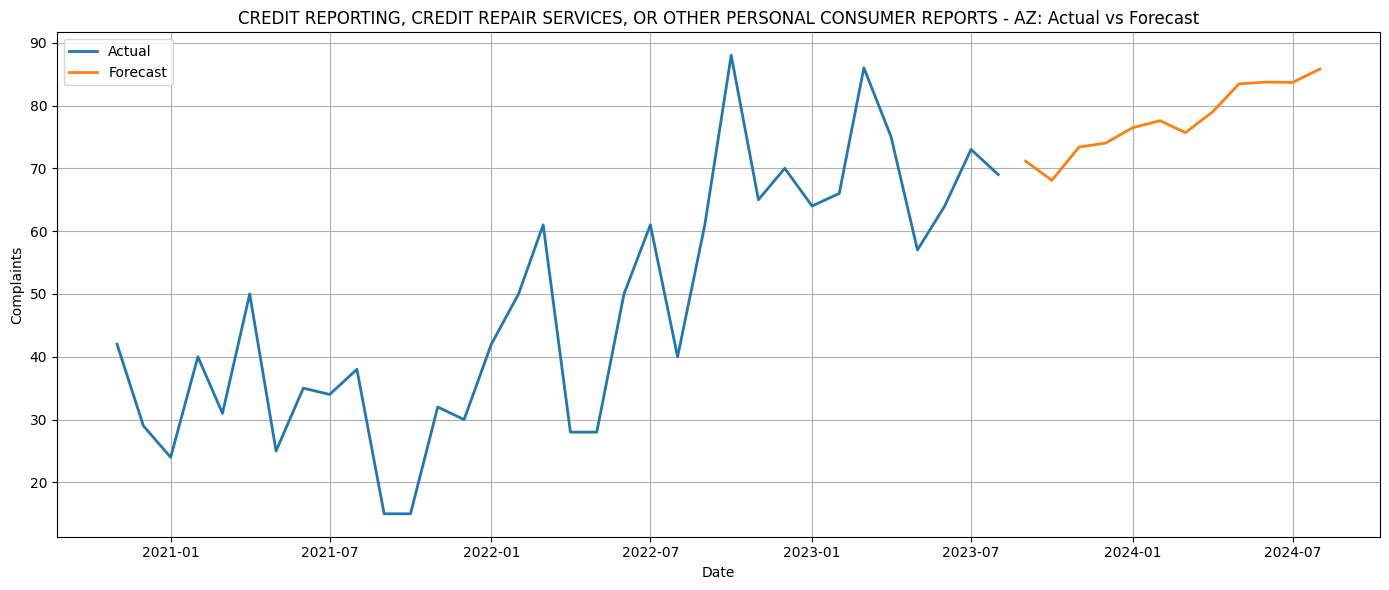

In [3]:

import pandas as pd
import matplotlib.pyplot as plt

# Load data
file = "/content/drive/MyDrive/Data_Science_Projects/Customer_Complaint_Trend_Forecasting/data/all_set_for_visuals.csv"
df = pd.read_csv(file, parse_dates=["ds"])

# ---- Using your chosen pair ----
product = "CREDIT REPORTING, CREDIT REPAIR SERVICES, OR OTHER PERSONAL CONSUMER REPORTS"
state = "AZ"
# --------------------------------

pair = df[(df["Product"] == product) & (df["State"] == state)]

# Separate actual & forecast
actual = pair[pair["actual_count"].notna()]
forecast = pair[pair["forecast_count"].notna()]

# Plot
plt.figure(figsize=(14,6))

plt.plot(actual["ds"], actual["actual_count"], label="Actual", linewidth=2)
plt.plot(forecast["ds"], forecast["forecast_count"], label="Forecast", linewidth=2)

plt.title(f"{product} - {state}: Actual vs Forecast")
plt.xlabel("Date")
plt.ylabel("Complaints")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

finding unstable pairs

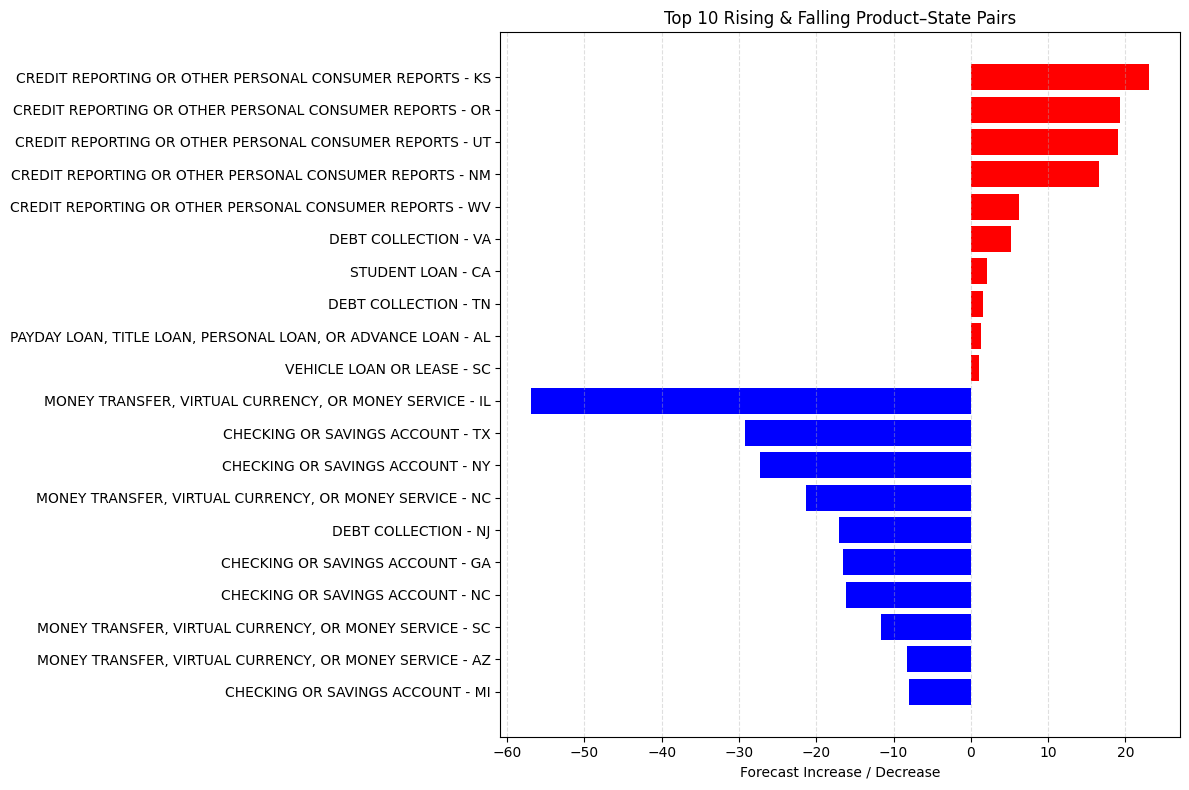

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/Data_Science_Projects/Customer_Complaint_Trend_Forecasting/data/all_set_for_visuals.csv")
df["ds"] = pd.to_datetime(df["ds"])
df["year"] = df["ds"].dt.year

# --- HISTORICAL MEAN (2024–2025) ---
hist = (
    df[(df["actual_count"].notna()) & (df["year"].isin([2024, 2025]))]
    .groupby(["Product", "State"])["actual_count"]
    .mean()
    .reset_index()
    .rename(columns={"actual_count": "hist_mean"})
)

# --- FORECAST MEAN (2026) ---
fut = (
    df[(df["forecast_count"].notna()) & (df["year"] == 2026)]
    .groupby(["Product", "State"])["forecast_count"]
    .mean()
    .reset_index()
    .rename(columns={"forecast_count": "future_mean"})
)

# --- MERGE ---
risk = pd.merge(hist, fut, on=["Product", "State"], how="inner")
risk["Risk_Score"] = risk["future_mean"] - risk["hist_mean"]

# --- Split top & bottom 10 ---
top10_risky = risk.sort_values("Risk_Score", ascending=False).head(10)
top10_safe  = risk.sort_values("Risk_Score", ascending=True).head(10)

# --- Combine for plotting ---
viz = pd.concat([top10_risky, top10_safe], axis=0)

# --- Label column ---
viz["Label"] = viz["Product"] + " - " + viz["State"]

# --- Plot ---
plt.figure(figsize=(12, 8))
colors = viz["Risk_Score"].apply(lambda x: "red" if x > 0 else "blue")

plt.barh(viz["Label"], viz["Risk_Score"], color=colors)

plt.xlabel("Forecast Increase / Decrease")
plt.title("Top 10 Rising & Falling Product–State Pairs")
plt.gca().invert_yaxis()  # Highest risk on top
plt.grid(axis='x', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

Root cause for risky pairs


=== TOP 10 RISKY PAIRS (Original Formula) ===
                                              Product State  historical_mean  \
19                        CREDIT CARD OR PREPAID CARD    FL        31.970588   
35  CREDIT REPORTING, CREDIT REPAIR SERVICES, OR O...    IN        39.558824   
33  CREDIT REPORTING, CREDIT REPAIR SERVICES, OR O...    AZ        48.176471   
28  CREDIT REPORTING OR OTHER PERSONAL CONSUMER RE...    KS        22.730769   
31  CREDIT REPORTING OR OTHER PERSONAL CONSUMER RE...    UT        20.730769   
30  CREDIT REPORTING OR OTHER PERSONAL CONSUMER RE...    OR        25.269231   
29  CREDIT REPORTING OR OTHER PERSONAL CONSUMER RE...    NM        20.080000   
20                        CREDIT CARD OR PREPAID CARD    GA        15.647059   
52                                    DEBT COLLECTION    VA        20.516667   
38  CREDIT REPORTING, CREDIT REPAIR SERVICES, OR O...    MS        38.147059   

    forecast_mean  risk_score  
19      78.546786   46.576198  
35      

<Figure size 1600x900 with 0 Axes>

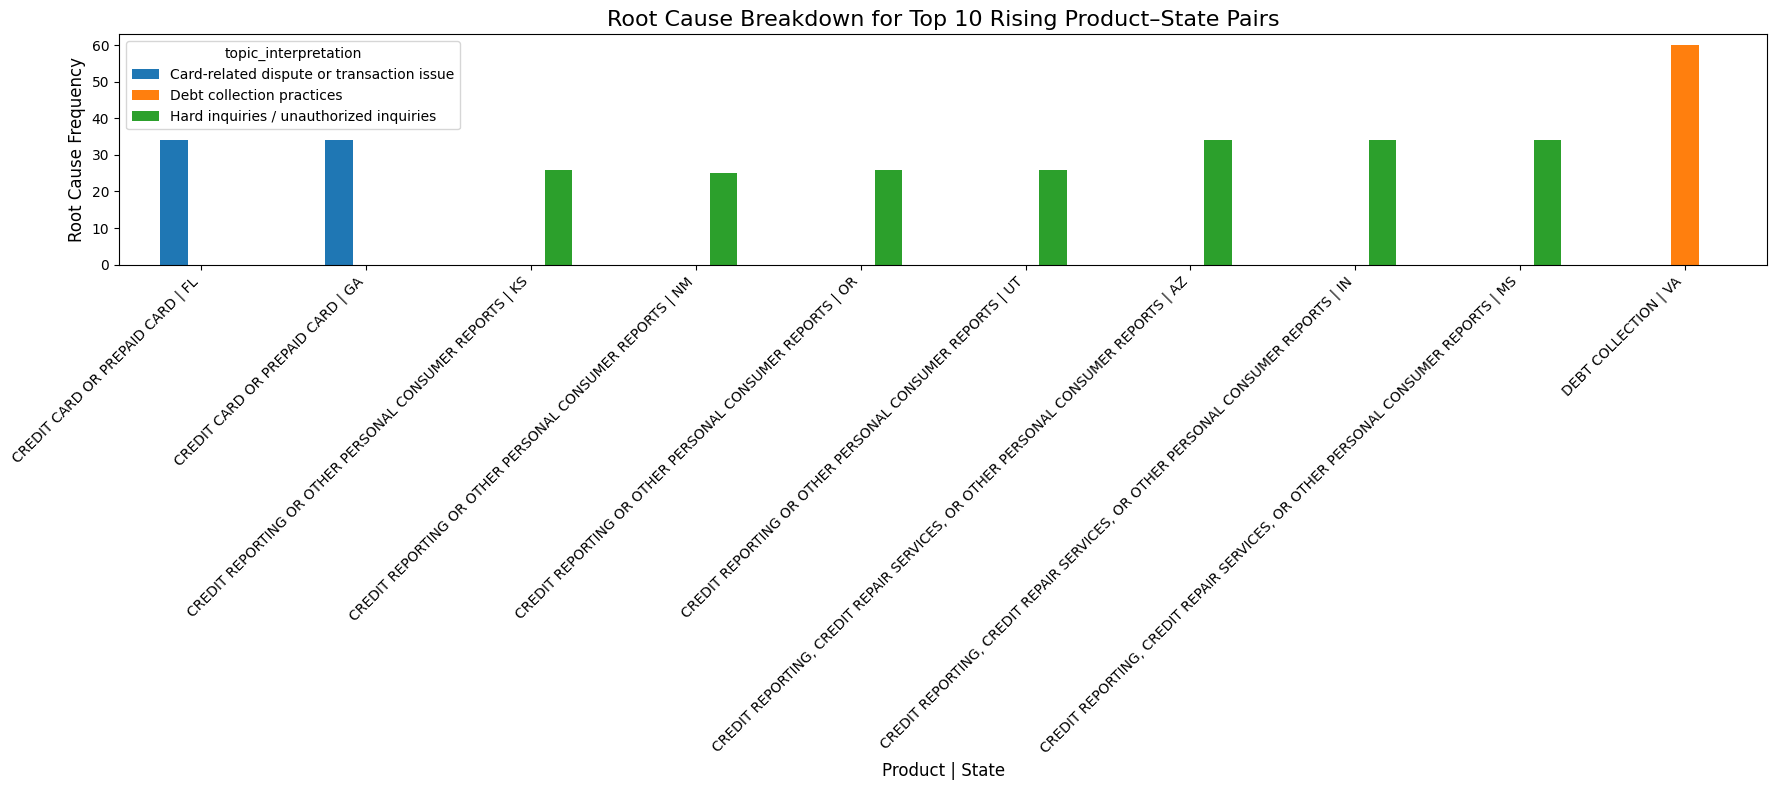

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("/content/drive/MyDrive/Data_Science_Projects/Customer_Complaint_Trend_Forecasting/data/all_set_for_visuals.csv")

# Convert ds to datetime
df["ds"] = pd.to_datetime(df["ds"])

# ------------------------------
# 1️⃣ Compute Historical Mean per pair
# ------------------------------
hist = (
    df[df["actual_count"].notna()]
    .groupby(["Product", "State"])["actual_count"]
    .mean()
    .reset_index()
    .rename(columns={"actual_count": "historical_mean"})
)

# ------------------------------
# 2️⃣ Compute Forecast Mean per pair
# ------------------------------
fc = (
    df[df["forecast_count"].notna()]
    .groupby(["Product", "State"])["forecast_count"]
    .mean()
    .reset_index()
    .rename(columns={"forecast_count": "forecast_mean"})
)

# ------------------------------
# 3️⃣ Merge and compute ORIGINAL risk_score
# ------------------------------
risk = pd.merge(hist, fc, on=["Product", "State"], how="inner")
risk["risk_score"] = risk["forecast_mean"] - risk["historical_mean"]

# ------------------------------
# 4️⃣ Pick Top 10 RISING pairs (highest positive score)
# ------------------------------
top10_risky = risk.nlargest(10, "risk_score")
print("\n=== TOP 10 RISKY PAIRS (Original Formula) ===")
print(top10_risky)

# ------------------------------
# 5️⃣ Extract only these pairs for root-cause visualization
# ------------------------------
pairs = list(zip(top10_risky["Product"], top10_risky["State"]))

root_df = df[
    (df[["Product", "State"]]
     .apply(tuple, axis=1)
     .isin(pairs))
]

# Use only historical rows (because forecast rows have null root-cause)
root_df = root_df[root_df["actual_count"].notna()]

# ------------------------------
# 6️⃣ Group root causes
# ------------------------------
root_count = (
    root_df.groupby(["Product", "State", "topic_interpretation"])
    .size()
    .reset_index(name="count")
)

# ------------------------------
# 7️⃣ PLOT — Grouped Bar Chart of Root Causes for Top 10 Rising Pairs
# ------------------------------

plt.figure(figsize=(16, 9))

# Create a combined key for x-axis
root_count["Pair"] = root_count["Product"] + " | " + root_count["State"]

# Pivot to create grouped bars
pivot_df = root_count.pivot(index="Pair", columns="topic_interpretation", values="count").fillna(0)

pivot_df.plot(kind="bar", figsize=(18, 8))

plt.title("Root Cause Breakdown for Top 10 Rising Product–State Pairs", fontsize=16)
plt.xlabel("Product | State", fontsize=12)
plt.ylabel("Root Cause Frequency", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

historical complaint volume per state

In [14]:
import pandas as pd
import plotly.graph_objects as go

# Load your data
df = pd.read_csv("/content/drive/MyDrive/Data_Science_Projects/Customer_Complaint_Trend_Forecasting/data/all_set_for_visuals.csv")

# Keep only historical (actual_count)
hist = df[df["actual_count"].notna()]

# Aggregate
state_summary = (
    hist.groupby("State")["actual_count"]
        .sum()
        .reset_index()
        .rename(columns={"actual_count": "total_complaints"})
)

# State center coordinates (needed for labels)
state_centers = {
    "AL":[32.806671,-86.791130], "AK":[61.370716,-152.404419],
    "AZ":[33.729759,-111.431221], "AR":[34.969704,-92.373123],
    "CA":[36.116203,-119.681564], "CO":[39.059811,-105.311104],
    "CT":[41.597782,-72.755371], "DC":[38.897438,-77.026817],
    "DE":[39.318523,-75.507141], "FL":[27.766279,-81.686783],
    "GA":[33.040619,-83.643074], "HI":[21.094318,-157.498337],
    "IA":[42.011539,-93.210526], "ID":[44.240459,-114.478828],
    "IL":[40.349457,-88.986137], "IN":[39.849426,-86.258278],
    "KS":[38.526600,-96.726486], "KY":[37.668140,-84.670067],
    "LA":[31.169546,-91.867805], "MA":[42.230171,-71.530106],
    "MD":[39.063946,-76.802101], "ME":[44.693947,-69.381927],
    "MI":[43.326618,-84.536095], "MN":[45.694454,-93.900192],
    "MO":[38.456085,-92.288368], "MS":[32.741646,-89.678696],
    "MT":[46.921925,-110.454353], "NC":[35.630066,-79.806419],
    "ND":[47.528912,-99.784012], "NE":[41.125370,-98.268082],
    "NH":[43.452492,-71.563896], "NJ":[40.298904,-74.521011],
    "NM":[34.840515,-106.248482], "NV":[38.313515,-117.055374],
    "NY":[42.165726,-74.948051], "OH":[40.388783,-82.764915],
    "OK":[35.565342,-96.928917], "OR":[44.572021,-122.070938],
    "PA":[40.590752,-77.209755], "RI":[41.680893,-71.511780],
    "SC":[33.856892,-80.945007], "SD":[44.299782,-99.438828],
    "TN":[35.747845,-86.692345], "TX":[31.054487,-97.563461],
    "UT":[40.150032,-111.862434], "VA":[37.769337,-78.169968],
    "VT":[44.045876,-72.710686], "WA":[47.400902,-121.490494],
    "WI":[44.268543,-89.616508], "WV":[38.491226,-80.954456],
    "WY":[42.755966,-107.302490], "PR":[18.220833,-66.590149],
    "GU":[13.444304,144.793732], "VI":[18.335764,-64.896335],
    "MP":[15.097900,145.673900], "AS":[-14.270972,-170.132217]
}

# Merge coordinates
state_summary["lat"] = state_summary["State"].map(lambda x: state_centers.get(x, [None,None])[0])
state_summary["lon"] = state_summary["State"].map(lambda x: state_centers.get(x, [None,None])[1])

# Create figure
fig = go.Figure(data=go.Choropleth(
    locations=state_summary["State"],
    z=state_summary["total_complaints"],
    locationmode="USA-states",
    colorscale="Reds",
    colorbar_title="Complaints",
))

# Add labels
fig.add_trace(go.Scattergeo(
    locationmode="USA-states",
    lon=state_summary["lon"],
    lat=state_summary["lat"],
    text=state_summary["total_complaints"].astype(int),
    mode="text",
    textfont=dict(size=10, color="black"),
    showlegend=False
))

fig.update_layout(
    title_text="Historical Complaint Volume by State (With Counts)",
    title_x=0.5,
    geo_scope="usa"
)

fig.show()